# OCRParser Text Location Demo

This notebook demonstrates the `locate_text()` feature of OCRParser, which uses vision models to semantically locate text in documents and return bounding box coordinates.


In [1]:
import os
import json
from pathlib import Path
from IPython.display import Image as IPythonImage, display, Markdown
from PIL import Image, ImageDraw, ImageFont

from aicapture import OCRParser, create_default_vision_model


Image path: ./data/c1.png
Image exists: True


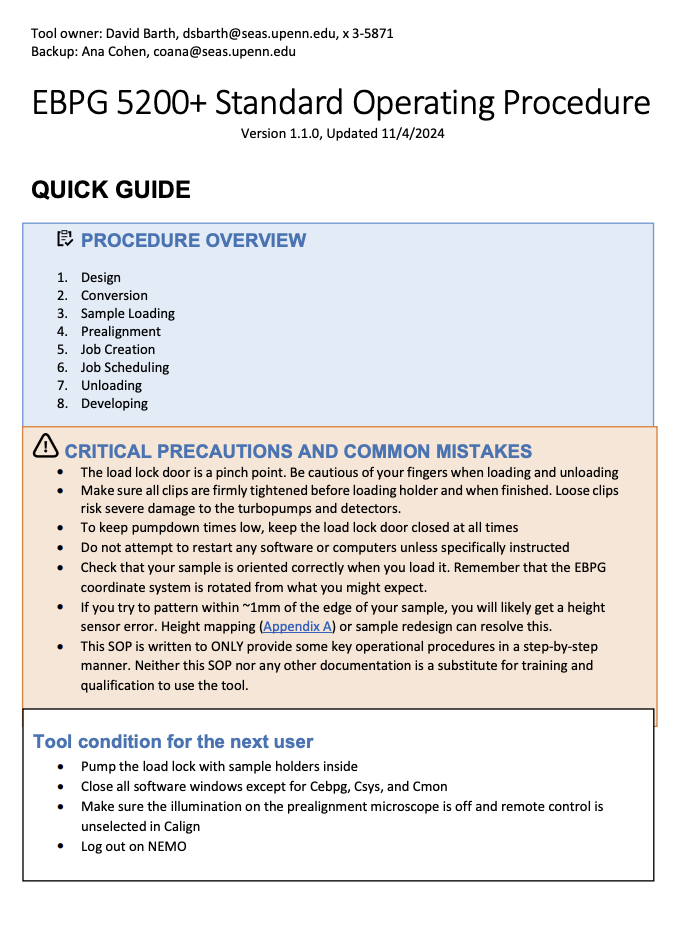

In [3]:
# Configuration
image_path = "./data/c1.png"
cache_dir = "./tmp/.orc_cache"

# Verify image exists
if not Path(image_path).exists():
    raise FileNotFoundError(f"Image not found: {image_path}")

print(f"Image path: {image_path}")
print(f"Image exists: {Path(image_path).exists()}")

# Display the image
display(IPythonImage(filename=image_path))


In [4]:
# Initialize OCRParser with auto-detected vision model
vision_model = create_default_vision_model()
print(f"Using vision model: {vision_model.__class__.__name__}")
print(f"Model: {vision_model.model}")

parser = OCRParser(
    vision_model=vision_model,
    cache_dir=cache_dir,
    use_bounding_box=True,
    use_confidence_score=True
)
print("\nOCRParser initialized successfully!")


2025-11-16 13:38:49.597 | INFO     | aicapture.vision_models:create_default_vision_model:32 - Creating vision model for provider: gemini
2025-11-16 13:38:49.597 | DEBUG    | aicapture.vision_models:__init__:135 - Using GeminiVisionModel
API Key: AIza***********************************
API Base: https://generativelanguage.googleapis.com/v1beta/openai/
Model: gemini-2.5-pro

2025-11-16 13:38:49.598 | WARNING  | aicapture.cache:__init__:355 - Parent directory tmp/.orc_cache does not exist. Creating it.
2025-11-16 13:38:49.599 | DEBUG    | aicapture.cache:__init__:360 - Initialized image cache at tmp/.orc_cache/images
2025-11-16 13:38:49.599 | DEBUG    | aicapture.cache:__init__:80 - Initialized file cache at tmp/.orc_cache


Using vision model: GeminiVisionModel
Model: gemini-2.5-pro

OCRParser initialized successfully!


## Example 1: Locate Specific Text

Let's search for "PROCEDURE OVERVIEW" in the document.


In [5]:
import nest_asyncio
nest_asyncio.apply()

# Locate text "PROCEDURE OVERVIEW"
query_text = "PROCEDURE OVERVIEW"
print(f"Searching for: '{query_text}'")

results = parser.locate_text(image_path, query_text)
print(f"\nResults: {json.dumps(results, indent=2)}")


2025-11-16 13:38:53.116 | DEBUG    | aicapture.ocr_parser:_locate_text_in_page_async:419 - Locating text 'PROCEDURE OVERVIEW' in page 1


Searching for: 'PROCEDURE OVERVIEW'


2025-11-16 13:39:05.505 | INFO     | aicapture.vision_models:log_token_usage:152 - Token usage: {'prompt_tokens': 534, 'completion_tokens': 51, 'total_tokens': 1368}
2025-11-16 13:39:05.506 | INFO     | aicapture.ocr_parser:_locate_text_in_page_async:427 - Found 1 matches for 'PROCEDURE OVERVIEW' in page 1



Results: {
  "page_1": [
    {
      "bbox": [
        120.0,
        245.0,
        450.0,
        270.0
      ],
      "text": "PROCEDURE OVERVIEW"
    }
  ]
}



page_1: Found 1 match(es)
  Match 1: bbox=[83, 227, 312, 250], text='PROCEDURE OVERVIEW...'


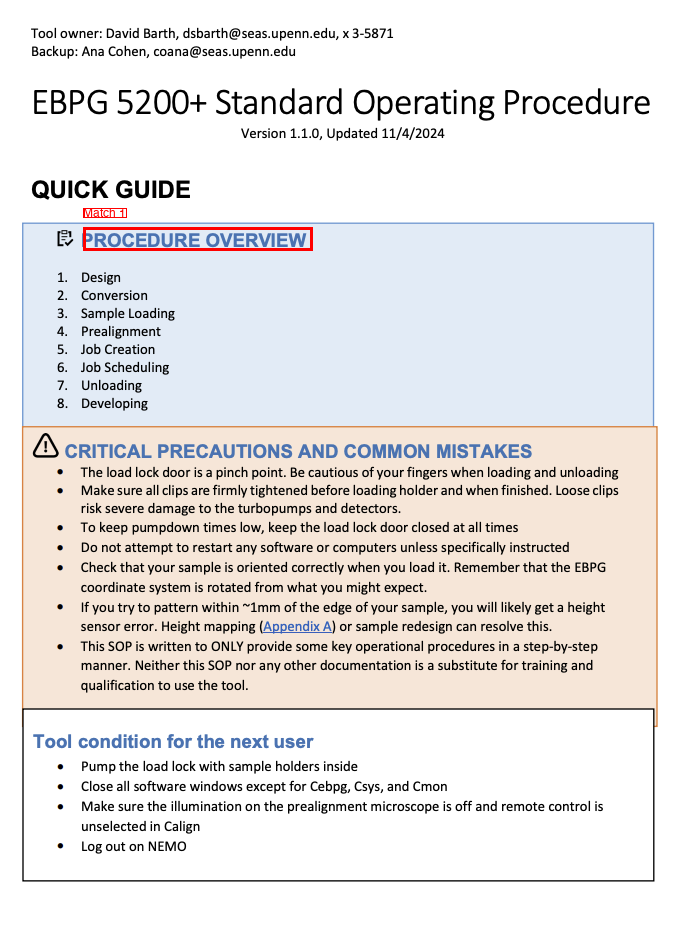

In [7]:
# Visualize the results by drawing bounding boxes on the image
def draw_bboxes_on_image(image_path, results, color="red", width=3):
    """Draw bounding boxes on the image based on locate_text results."""
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    
    img_width, img_height = img.size
    
    for page_key, matches in results.items():
        print(f"\n{page_key}: Found {len(matches)} match(es)")
        for i, match in enumerate(matches, 1):
            bbox = match["bbox"]
            text = match.get("text", "")
            confidence = match.get("confidence")
            
            # Convert normalized coordinates (0-1000) to pixel coordinates
            xmin, ymin, xmax, ymax = bbox
            x0 = int(xmin * img_width / 1000)
            y0 = int(ymin * img_height / 1000)
            x1 = int(xmax * img_width / 1000)
            y1 = int(ymax * img_height / 1000)
            
            # Draw rectangle
            draw.rectangle([x0, y0, x1, y1], outline=color, width=width)
            
            # Add label
            label = f"Match {i}"
            if confidence is not None:
                label += f" (conf: {confidence})"
            
            try:
                font = ImageFont.truetype("/System/Library/Fonts/Helvetica.ttc", 12)
            except:
                try:
                    font = ImageFont.load_default()
                except:
                    font = None
            
            if font:
                # Draw text background
                bbox_text = draw.textbbox((x0, y0 - 20), label, font=font)
                draw.rectangle(bbox_text, fill="white", outline=color)
                draw.text((x0, y0 - 20), label, fill=color, font=font)
            
            print(f"  Match {i}: bbox=[{x0}, {y0}, {x1}, {y1}], text='{text[:50]}...'")
    
    return img

# Draw bounding boxes for the first query
if results:
    img_with_boxes = draw_bboxes_on_image(image_path, results, color="red")
    display(img_with_boxes)
else:
    print("No matches found.")


## Example 2: Locate Text with Semantic Matching

The locate_text feature can find text that doesn't exactly match. Let's search for "email" which might appear in different forms.


2025-11-16 13:39:25.229 | DEBUG    | aicapture.ocr_parser:_locate_text_in_page_async:419 - Locating text 'email' in page 1


Searching for: 'email'


2025-11-16 13:39:35.775 | INFO     | aicapture.vision_models:log_token_usage:152 - Token usage: {'prompt_tokens': 530, 'completion_tokens': 98, 'total_tokens': 1254}
2025-11-16 13:39:35.776 | INFO     | aicapture.ocr_parser:_locate_text_in_page_async:427 - Found 2 matches for 'email' in page 1



Results: {
  "page_1": [
    {
      "bbox": [
        306.0,
        26.0,
        559.0,
        43.0
      ],
      "text": "dsbarth@seas.upenn.edu"
    },
    {
      "bbox": [
        255.0,
        48.0,
        498.0,
        65.0
      ],
      "text": "coana@seas.upenn.edu"
    }
  ]
}

page_1: Found 2 match(es)
  Match 1: bbox=[212, 24, 387, 39], text='dsbarth@seas.upenn.edu...'
  Match 2: bbox=[176, 44, 345, 60], text='coana@seas.upenn.edu...'


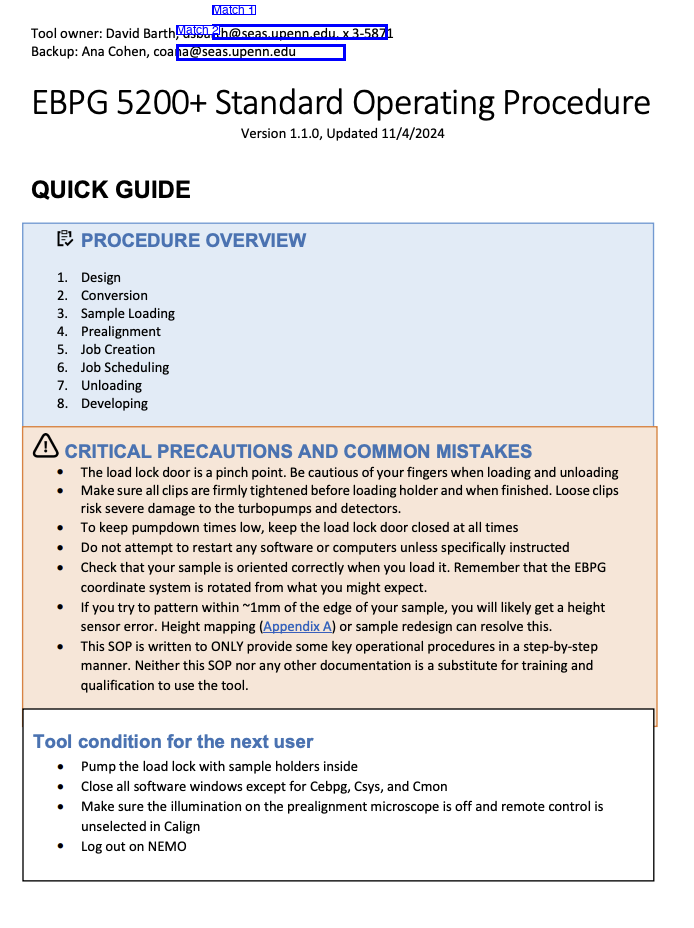

In [8]:
# Search for email addresses (semantic matching)
query_text = "email"
print(f"Searching for: '{query_text}'")

results_email = parser.locate_text(image_path, query_text)
print(f"\nResults: {json.dumps(results_email, indent=2)}")

if results_email:
    img_with_boxes = draw_bboxes_on_image(image_path, results_email, color="blue")
    display(img_with_boxes)
else:
    print("No matches found.")


## Example 3: Locate Multiple Text Instances

Let's search for "CRITICAL" which might appear multiple times in the document.


2025-11-16 13:39:41.621 | DEBUG    | aicapture.ocr_parser:_locate_text_in_page_async:419 - Locating text 'CRITICAL' in page 1


Searching for: 'CRITICAL'


2025-11-16 13:39:55.110 | INFO     | aicapture.vision_models:log_token_usage:152 - Token usage: {'prompt_tokens': 531, 'completion_tokens': 48, 'total_tokens': 1476}
2025-11-16 13:39:55.111 | INFO     | aicapture.ocr_parser:_locate_text_in_page_async:427 - Found 1 matches for 'CRITICAL' in page 1



Results: {
  "page_1": [
    {
      "bbox": [
        120.0,
        475.0,
        274.0,
        495.0
      ],
      "text": "CRITICAL"
    }
  ]
}

page_1: Found 1 match(es)
  Match 1: bbox=[83, 440, 190, 459], text='CRITICAL...'


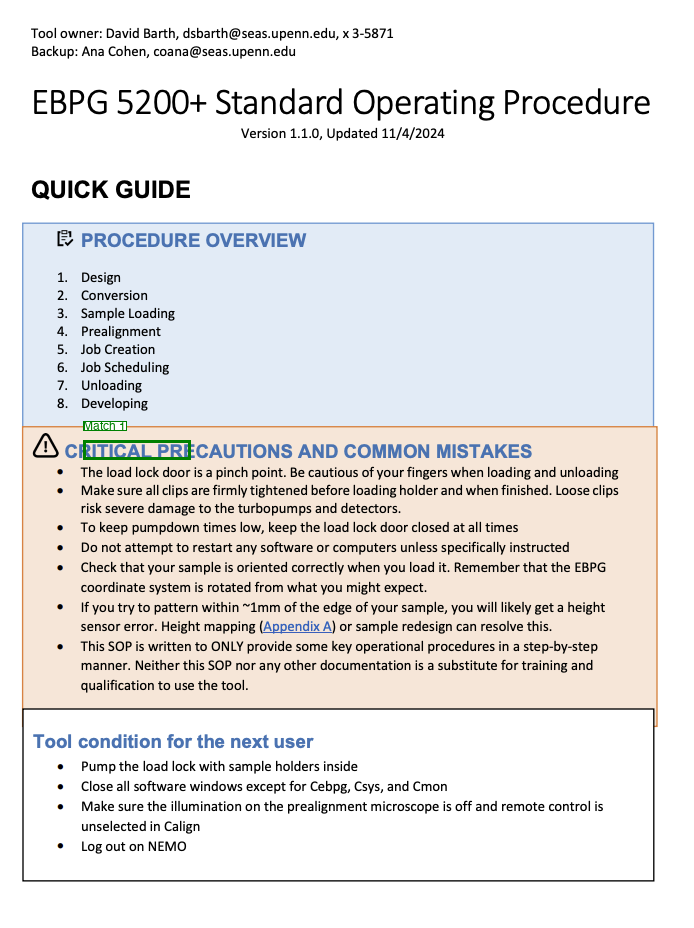

In [9]:
# Search for "CRITICAL" - should find "CRITICAL PRECAUTIONS"
query_text = "CRITICAL"
print(f"Searching for: '{query_text}'")

results_critical = parser.locate_text(image_path, query_text)
print(f"\nResults: {json.dumps(results_critical, indent=2)}")

if results_critical:
    img_with_boxes = draw_bboxes_on_image(image_path, results_critical, color="green")
    display(img_with_boxes)
else:
    print("No matches found.")


## Example 4: Using Async Method

For better performance with multiple queries or large documents, use the async method.


In [10]:
import asyncio
import nest_asyncio

# Enable nested event loops in Jupyter
nest_asyncio.apply()

# Use async method
async def locate_multiple_queries():
    queries = ["PROCEDURE OVERVIEW", "Tool owner", "QUICK GUIDE"]
    results = {}
    
    for query in queries:
        result = await parser.locate_text_async(image_path, query)
        results[query] = result
        print(f"Query: '{query}' -> Found matches on {len(result)} page(s)")
    
    return results

# Run async queries
async_results = asyncio.run(locate_multiple_queries())
print("\nAll results:")
print(json.dumps(async_results, indent=2))


2025-11-16 13:40:06.988 | DEBUG    | aicapture.ocr_parser:_locate_text_in_page_async:419 - Locating text 'PROCEDURE OVERVIEW' in page 1
2025-11-16 13:40:18.109 | INFO     | aicapture.vision_models:log_token_usage:152 - Token usage: {'prompt_tokens': 534, 'completion_tokens': 51, 'total_tokens': 1368}
2025-11-16 13:40:18.110 | INFO     | aicapture.ocr_parser:_locate_text_in_page_async:427 - Found 1 matches for 'PROCEDURE OVERVIEW' in page 1
2025-11-16 13:40:18.123 | DEBUG    | aicapture.ocr_parser:_locate_text_in_page_async:419 - Locating text 'Tool owner' in page 1


Query: 'PROCEDURE OVERVIEW' -> Found matches on 1 page(s)


2025-11-16 13:40:29.266 | INFO     | aicapture.vision_models:log_token_usage:152 - Token usage: {'prompt_tokens': 531, 'completion_tokens': 45, 'total_tokens': 1494}
2025-11-16 13:40:29.267 | INFO     | aicapture.ocr_parser:_locate_text_in_page_async:427 - Found 1 matches for 'Tool owner' in page 1
2025-11-16 13:40:29.281 | DEBUG    | aicapture.ocr_parser:_locate_text_in_page_async:419 - Locating text 'QUICK GUIDE' in page 1


Query: 'Tool owner' -> Found matches on 1 page(s)


2025-11-16 13:40:39.774 | INFO     | aicapture.vision_models:log_token_usage:152 - Token usage: {'prompt_tokens': 532, 'completion_tokens': 90, 'total_tokens': 1352}
2025-11-16 13:40:39.774 | INFO     | aicapture.ocr_parser:_locate_text_in_page_async:427 - Found 2 matches for 'QUICK GUIDE' in page 1


Query: 'QUICK GUIDE' -> Found matches on 1 page(s)

All results:
{
  "PROCEDURE OVERVIEW": {
    "page_1": [
      {
        "bbox": [
          120.0,
          245.0,
          450.0,
          270.0
        ],
        "text": "PROCEDURE OVERVIEW"
      }
    ]
  },
  "Tool owner": {
    "page_1": [
      {
        "bbox": [
          44.0,
          23.0,
          158.0,
          39.0
        ],
        "text": "Tool owner"
      }
    ]
  },
  "QUICK GUIDE": {
    "page_1": [
      {
        "bbox": [
          44.0,
          188.0,
          220.0,
          212.0
        ],
        "text": "QUICK GUIDE"
      },
      {
        "bbox": [
          80.0,
          245.0,
          450.0,
          265.0
        ],
        "text": "PROCEDURE OVERVIEW"
      }
    ]
  }
}


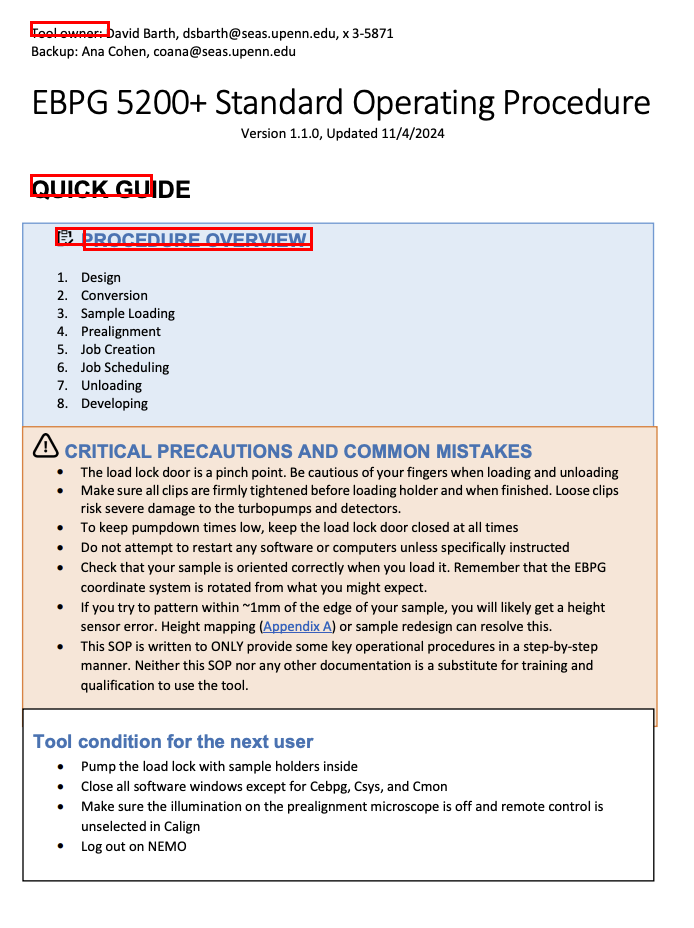

In [11]:
# Draw all bounding boxes from all queried results on a single image

from PIL import Image, ImageDraw

def draw_all_bboxes_on_image(image_path, all_results, color="red", width=3):
    """
    Draw bounding boxes from multiple queries (all_results) on a single image.
    Expects all_results: {query_text: {page_N: [matches, ...], ...}, ...}
    Only handles page_1 by default.
    """
    # Load image
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    
    for query, query_result in all_results.items():
        for page_key, matches in query_result.items():
            # Optionally, only visualize for page_1 here
            for match in matches:
                bbox = match["bbox"]
                # Convert normalized bbox (0-1000) to image size
                xmin, ymin, xmax, ymax = bbox
                im_w, im_h = img.size
                x1 = int(xmin / 1000 * im_w)
                y1 = int(ymin / 1000 * im_h)
                x2 = int(xmax / 1000 * im_w)
                y2 = int(ymax / 1000 * im_h)
                # Draw rectangle
                draw.rectangle([x1, y1, x2, y2], outline=color, width=width)
                # Optionally, label with the query text
                #draw.text((x1, y1-12), f"{query}", fill=color)
    return img

if async_results:
    img_with_boxes = draw_all_bboxes_on_image(image_path, async_results, color="red")
    display(img_with_boxes)
else:
    print("No matches found.")

## Summary

The `locate_text()` method:
- Uses vision models to semantically locate text in documents
- Returns bounding boxes in normalized format (0-1000 scale)
- Supports both exact and fuzzy/semantic matching
- Works with both images and PDFs
- Returns results grouped by page number
- Includes matched text snippets and optional confidence scores
